In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt

visits = pd.read_csv('visits.csv')
orders = pd.read_csv('orders.csv')
costs = pd.read_csv('costs.csv')

In [3]:
print(visits.info())
print(visits.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
Uid          358532 non-null uint64
Device       358532 non-null object
End Ts       358532 non-null object
Source Id    358532 non-null int64
Start Ts     358532 non-null object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None
                    Uid   Device            End Ts  Source Id  \
0  16879256277535980062    touch  20.12.2017 17:38          4   
1    104060357244891740  desktop  19.02.2018 17:21          2   
2   7459035603376831527    touch   01.07.2017 1:54          5   
3  16174680259334210214  desktop  20.05.2018 11:23          9   
4   9969694820036681168  desktop  27.12.2017 14:06          3   

           Start Ts  
0  20.12.2017 17:20  
1  19.02.2018 16:53  
2   01.07.2017 1:54  
3  20.05.2018 10:59  
4  27.12.2017 14:06  


In [4]:
print(orders.info())
print(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None
                Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450


In [5]:
print(costs.info())
print(costs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None
   source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08


Переименуем столбцы

In [6]:
visits.set_axis(['user_id', 'device', 'end_time', 'source_id', 'start_time'], axis = 'columns', inplace = True)
orders.set_axis(['buy_time', 'sale', 'user_id'], axis = 'columns', inplace = True)
costs.set_axis(['source_id', 'date', 'costs'], axis = 'columns', inplace = True)

Добавим id сессии

In [7]:
id_counter = 1
    
def do_id(data):
    global id_counter
    id_to_return = id_counter
    id_counter = id_counter + 1
    return id_to_return

visits['session_id'] = visits.apply(do_id, axis=1)

Переведем тип данных в дату, где это необходимо

In [8]:
visits['start_time'] = pd.to_datetime(visits['start_time'], format='%d.%m.%Y %H:%M')
visits['end_time'] = pd.to_datetime(visits['end_time'], format='%d.%m.%Y %H:%M')
orders['buy_time'] = pd.to_datetime(orders['buy_time'], format='%Y-%m-%d %H:%M:%S')
costs['date'] = pd.to_datetime(costs['date'], format='%Y-%m-%d')

In [9]:
visits['day'] = visits['start_time'].dt.date
orders['day'] = orders['buy_time'].dt.date

Добавим таблицу orders к visits

In [10]:
#Создаю таблицу, где просто склеиваю visits и orders по 'user_id', 'day'
visits_merge = visits.merge(orders, on = ['user_id', 'day'], how = 'left')

In [11]:
#Отсеиваю те строки, которые не удовлетворяют условию end_time >= buy_time >= start_time
visits_merge = visits_merge.query('end_time >= buy_time >= start_time')

In [12]:
#Получившуюся таблицу еще раз клею к основной
visits = visits.merge(visits_merge, on = ['user_id', 
                                          'device', 
                                          'end_time', 
                                          'source_id', 
                                          'start_time', 
                                          'session_id', 
                                          'day'], 
                      how = 'left')

In [13]:
print(visits.info())
print(visits.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358532 entries, 0 to 358531
Data columns (total 9 columns):
user_id       358532 non-null uint64
device        358532 non-null object
end_time      358532 non-null datetime64[ns]
source_id     358532 non-null int64
start_time    358532 non-null datetime64[ns]
session_id    358532 non-null int64
day           358532 non-null object
buy_time      34874 non-null datetime64[ns]
sale          34874 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(2), object(2), uint64(1)
memory usage: 27.4+ MB
None
                user_id   device            end_time  source_id  \
0  16879256277535980062    touch 2017-12-20 17:38:00          4   
1    104060357244891740  desktop 2018-02-19 17:21:00          2   
2   7459035603376831527    touch 2017-07-01 01:54:00          5   
3  16174680259334210214  desktop 2018-05-20 11:23:00          9   
4   9969694820036681168  desktop 2017-12-27 14:06:00          3   

           start_time  session_id  

Строк стало больше, выясним с чем это связано, возможно с тем что за одну сессию могло совершаться несколько покупок

In [14]:
print('Количество сессий', visits['session_id'].nunique())

Количество сессий 358532


Сессий столько же, получается было несколько покупок в какие-то из сессий

Добавим данные по: 

-дате, недели, месяцу(в том числе месяца от 00.00.0000), году

In [15]:
visits['start_time_day'] = visits['start_time'].dt.date
visits['start_time_week'] = visits['start_time'].dt.week
visits['start_time_month'] = visits['start_time'].dt.month
visits['start_time_year'] = visits['start_time'].dt.year
visits['start_month_from_zero'] = visits['start_time_year'] * 12 + visits['start_time_month']

visits['end_time_day'] = visits['end_time'].dt.date
visits['end_time_week'] = visits['end_time'].dt.week
visits['end_time_month'] = visits['end_time'].dt.month
visits['end_time_year'] = visits['end_time'].dt.year
visits['end_month_from_zero'] = visits['end_time_year'] * 12 + visits['end_time_month']

visits['buy_time_day'] = visits['buy_time'].dt.date
visits['buy_time_week'] = visits['buy_time'].dt.week
visits['buy_time_month'] = visits['buy_time'].dt.month
visits['buy_time_year'] = visits['buy_time'].dt.year
visits['buy_month_from_zero'] = visits['buy_time_year'] * 12 + visits['buy_time_month']

orders['buy_time_day'] = orders['buy_time'].dt.date
orders['buy_time_week'] = orders['buy_time'].dt.week
orders['buy_time_month'] = orders['buy_time'].dt.month
orders['buy_time_year'] = orders['buy_time'].dt.year

costs['costs_date_day'] = costs['date'].dt.date
costs['costs_date_week'] = costs['date'].dt.week
costs['costs_date_month'] = costs['date'].dt.month
costs['costs_date_year'] = costs['date'].dt.year

-длительности сессии

In [16]:
visits['duration'] = ((visits['end_time'] - visits['start_time'])/ np.timedelta64(1,'s')).astype(int)

-время первого действия

In [17]:
visits_first_activity_date = visits.groupby('user_id')['start_time'].min()
visits_first_activity_date.name = 'first_activity_time'
visits = visits.join(visits_first_activity_date,on='user_id')

In [18]:
visits_first_activity_date = visits.groupby('user_id')['start_month_from_zero'].min()
visits_first_activity_date.name = 'first_activity_month_from_zero'
visits = visits.join(visits_first_activity_date,on='user_id')

In [19]:
visits_first_buy_date = visits.groupby('user_id')['buy_time'].min()
visits_first_buy_date.name = 'first_buy_time'
visits = visits.join(visits_first_buy_date,on='user_id')

In [20]:
orders_first_activity_date = orders.groupby('user_id')['buy_time'].min()
orders_first_activity_date.name = 'first_buy_time'
orders = orders.join(orders_first_activity_date,on='user_id')

In [21]:
visits_first_buy_month_from_zero = visits.groupby('user_id')['buy_month_from_zero'].min()
visits_first_buy_month_from_zero.name = 'first_buy_month_from_zero'
visits = visits.join(visits_first_buy_month_from_zero,on='user_id')

-время жизни

In [22]:
visits['lifetime'] = visits['end_time'].dt.date - visits['first_activity_time'].dt.date

visits['buy_lifetime'] = visits['buy_time'].dt.date - visits['first_activity_time'].dt.date

orders['buy_lifetime'] = orders['buy_time'].dt.date - orders['first_buy_time'].dt.date

In [23]:
print(visits.info())
print(visits.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358532 entries, 0 to 358531
Data columns (total 31 columns):
user_id                           358532 non-null uint64
device                            358532 non-null object
end_time                          358532 non-null datetime64[ns]
source_id                         358532 non-null int64
start_time                        358532 non-null datetime64[ns]
session_id                        358532 non-null int64
day                               358532 non-null object
buy_time                          34874 non-null datetime64[ns]
sale                              34874 non-null float64
start_time_day                    358532 non-null object
start_time_week                   358532 non-null int64
start_time_month                  358532 non-null int64
start_time_year                   358532 non-null int64
start_month_from_zero             358532 non-null int64
end_time_day                      358532 non-null object
end_time_week    

In [24]:
print(orders.info())
print(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 10 columns):
buy_time          50415 non-null datetime64[ns]
sale              50415 non-null float64
user_id           50415 non-null uint64
day               50415 non-null object
buy_time_day      50415 non-null object
buy_time_week     50415 non-null int64
buy_time_month    50415 non-null int64
buy_time_year     50415 non-null int64
first_buy_time    50415 non-null datetime64[ns]
buy_lifetime      50415 non-null timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(2), timedelta64[ns](1), uint64(1)
memory usage: 3.8+ MB
None
             buy_time   sale               user_id         day buy_time_day  \
0 2017-06-01 00:10:00  17.00  10329302124590727494  2017-06-01   2017-06-01   
1 2017-06-01 00:25:00   0.55  11627257723692907447  2017-06-01   2017-06-01   
2 2017-06-01 00:27:00   0.37  17903680561304213844  2017-06-01   2017-06-01   
3 2017-06-01 00:29:00   0.55  16109

In [25]:
print(costs.info())
print(costs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 7 columns):
source_id           2542 non-null int64
date                2542 non-null datetime64[ns]
costs               2542 non-null float64
costs_date_day      2542 non-null object
costs_date_week     2542 non-null int64
costs_date_month    2542 non-null int64
costs_date_year     2542 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 139.1+ KB
None
   source_id       date  costs costs_date_day  costs_date_week  \
0          1 2017-06-01  75.20     2017-06-01               22   
1          1 2017-06-02  62.25     2017-06-02               22   
2          1 2017-06-03  36.53     2017-06-03               22   
3          1 2017-06-04  55.00     2017-06-04               22   
4          1 2017-06-05  57.08     2017-06-05               23   

   costs_date_month  costs_date_year  
0                 6             2017  
1                 6             2017  


Данные в порядке

Построим отчеты и посчитаем метрики

Продукт:

Посчитаем DAU, WAU, MAU по посещениям

In [26]:
dau_use = visits.groupby('start_time_day').agg({'user_id': 'nunique'}).mean().round().astype('int')
wau_use = visits.groupby(['start_time_year', 'start_time_week']).agg({'user_id': 'nunique'}).mean().round().astype('int')
mau_use = visits.groupby(['start_time_year', 'start_time_month']).agg({'user_id': 'nunique'}).mean().round().astype('int')

print('Среднее колличество людей, которые используют продукт, в день:', dau_use)
print('Среднее колличество людей, которые используют продукт, в неделю:', wau_use)
print('Среднее колличество людей, которые используют продукт, в месяц:', mau_use)

Среднее колличество людей, которые используют продукт, в день: user_id    908
dtype: int32
Среднее колличество людей, которые используют продукт, в неделю: user_id    5716
dtype: int32
Среднее колличество людей, которые используют продукт, в месяц: user_id    23228
dtype: int32


Медианное число сессий в день: session_id    999.5
dtype: float64


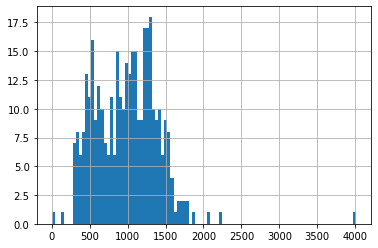

In [27]:
dau_session = visits.groupby('start_time_day').agg({'session_id': 'count'})
dau_session['session_id'].hist(bins = 100)
print('Медианное число сессий в день:', dau_session.median())

Медианное время сессии(в секундах): 300.0


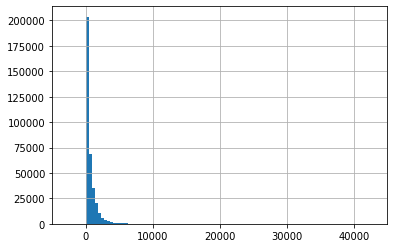

In [28]:
visits['duration'].hist(bins = 100)

print('Медианное время сессии(в секундах):', visits['duration'].median())

In [29]:
visits_uniq_user_id = visits.groupby('user_id').agg({'duration': 'max', 'lifetime': 'max'})
visits_uniq_user_id['lifetime'] = (visits_uniq_user_id['lifetime']/ np.timedelta64(1,'s')).astype(int)
#Создадим столбец в котором отметим один раз к нам заходил посетитель или нет
visits_uniq_user_id['reverse'] = visits_uniq_user_id['lifetime'] == visits_uniq_user_id['duration']
print('Процент вернувшихся пользователей:', 
      (visits_uniq_user_id[visits_uniq_user_id['reverse'] == False]['reverse'].count() / visits_uniq_user_id['reverse'].count() * 100).round(2))

Процент вернувшихся пользователей: 90.85


In [30]:
visits['month_lifetime'] = visits['end_month_from_zero'] - visits['first_activity_month_from_zero']

24210 - июнь 2017
24221 - май 2018


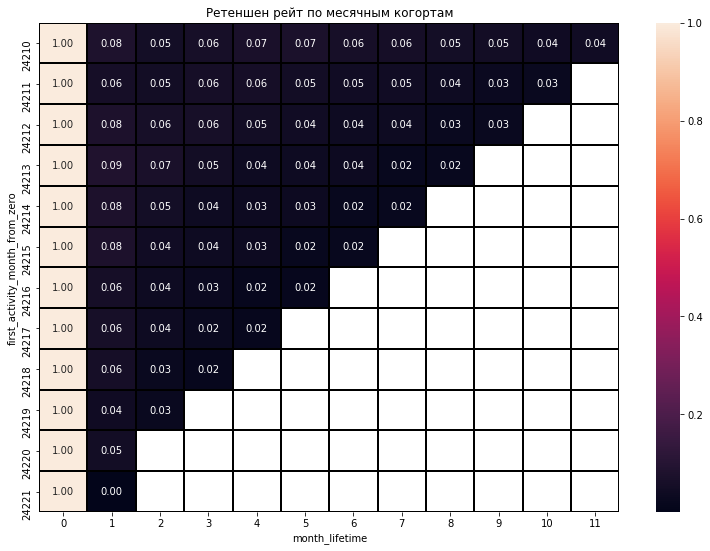

In [31]:
cohorts = visits.groupby(['first_activity_month_from_zero','month_lifetime']).agg({'user_id':'nunique'}).reset_index()

initial_users_count = cohorts[cohorts['month_lifetime'] == 0][['first_activity_month_from_zero','user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_activity_month_from_zero')

cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_activity_month_from_zero',columns='month_lifetime',values='retention',aggfunc='sum')

print("""24210 - июнь 2017
24221 - май 2018""")
plt.figure(figsize=(13, 9))
plt.title('Ретеншен рейт по месячным когортам')
sns.heatmap(retention_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black')

Продажи:

Мода времени между первым заходом на сайт и первой покупкой(в секундах): 0    60.0
dtype: float64


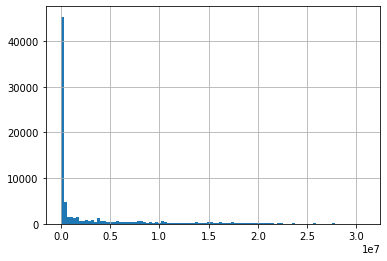

In [32]:
visits['time_to_buy'] = (visits['first_buy_time'] - visits['first_activity_time'])/ np.timedelta64(1,'s')
visits['time_to_buy'].hist(bins = 100)
print('Мода времени между первым заходом на сайт и первой покупкой(в секундах):', visits['time_to_buy'].mode())

Посчитаем DAU, WAU, MAU по покупкам

In [33]:
dau_buy = orders.groupby('buy_time_day').agg({'user_id': 'nunique'}).mean().round().astype('int')
wau_buy = orders.groupby(['buy_time_year', 'buy_time_week']).agg({'user_id': 'nunique'}).mean().round().astype('int')
mau_buy = orders.groupby(['buy_time_year', 'buy_time_month']).agg({'user_id': 'nunique'}).mean().round().astype('int')

print('Среднее колличество людей, которые покупают продукт, в день:', dau_buy)
print('Среднее колличество людей, которые покупают продукт, в неделю:', wau_buy)
print('Среднее колличество людей, которые покупают продукт, в месяц:', mau_buy)

Среднее колличество людей, которые покупают продукт, в день: user_id    128
dtype: int32
Среднее колличество людей, которые покупают продукт, в неделю: user_id    817
dtype: int32
Среднее колличество людей, которые покупают продукт, в месяц: user_id    3155
dtype: int32


24210 - июнь 2017
24221 - май 2018


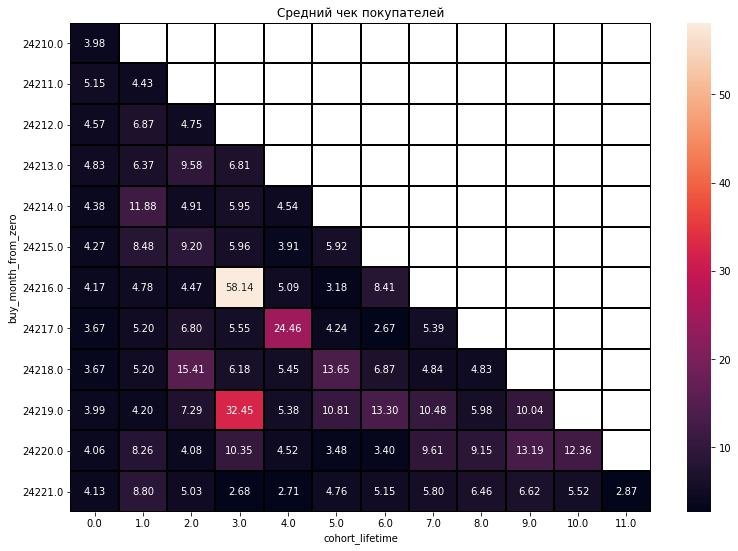

In [34]:
#Групируем таблицу по месяцу покупки и первому месяцу покупки с количиством уникальных сессий и суммой продаж
visits_grouped_by_cohorts = visits.groupby(['buy_month_from_zero', 'first_buy_month_from_zero']).agg({'session_id':'nunique','sale':'sum'})
#Находим сумму продаж за сессию
visits_grouped_by_cohorts['sales_per_session'] = visits_grouped_by_cohorts['sale']/visits_grouped_by_cohorts['session_id']
visits_grouped_by_cohorts = visits_grouped_by_cohorts.reset_index()
#Узнаем время жизни кагорты
visits_grouped_by_cohorts['cohort_lifetime'] = visits_grouped_by_cohorts['buy_month_from_zero'] - visits_grouped_by_cohorts['first_buy_month_from_zero']
#Делаем сводную таблицу по месяцу покупки, времени жизни когорты, значения - сумму продаж за сессию
lifetime_pivot = visits_grouped_by_cohorts.pivot_table(index='buy_month_from_zero',columns='cohort_lifetime',values='sales_per_session',aggfunc='mean')

print("""24210 - июнь 2017
24221 - май 2018""")
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(lifetime_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black')

In [35]:
cohort_sizes = visits.groupby('first_buy_month_from_zero').agg({'user_id': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month_from_zero', 'n_buyers']

cohorts = visits.groupby(['first_buy_month_from_zero','buy_month_from_zero']).agg({'sale': 'sum'}).reset_index()

report = pd.merge(cohort_sizes, cohorts, on='first_buy_month_from_zero')

24210 - июнь 2017
24221 - май 2018


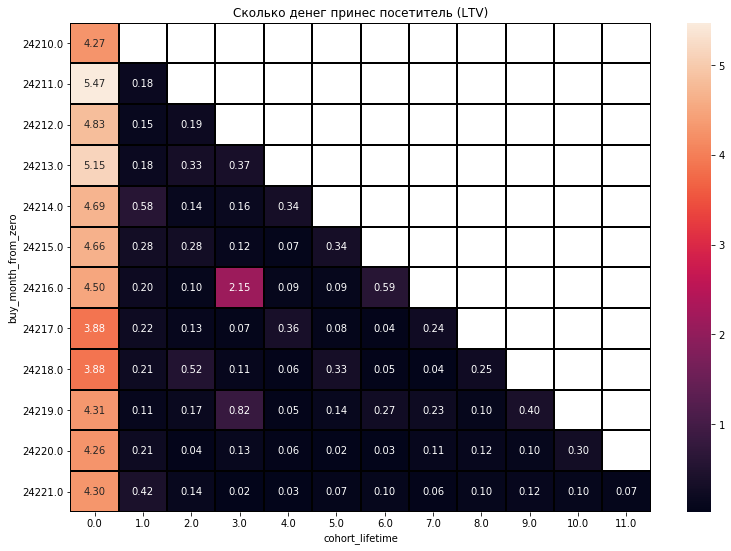

In [36]:
#То же самое только не по сессиям, а по пользователям

report['sales_per_user'] = report['sale']/report['n_buyers']
report = report.reset_index()

report['cohort_lifetime'] = report['buy_month_from_zero'] - report['first_buy_month_from_zero']

lifetime_pivot = report.pivot_table(index='buy_month_from_zero',columns='cohort_lifetime',values='sales_per_user',aggfunc='mean')

print("""24210 - июнь 2017
24221 - май 2018""")
plt.figure(figsize=(13, 9))
plt.title('Сколько денег принес посетитель (LTV)')
sns.heatmap(lifetime_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black')

In [37]:
lifetime_pivot

cohort_lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
buy_month_from_zero,,,,,,,,,,,,
24210.0,4.265539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24211.0,5.473731,0.180917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24212.0,4.832396,0.147437,0.193801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24213.0,5.150456,0.175129,0.332557,0.372940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24214.0,4.691101,0.576364,0.139441,0.161509,0.335048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24215.0,4.660380,0.277043,0.278482,0.121579,0.073984,0.337652,NaN,NaN,NaN,NaN,NaN,NaN
24216.0,4.495411,0.204062,0.095632,2.150413,0.094933,0.090246,0.592085,NaN,NaN,NaN,NaN,NaN
24217.0,3.882667,0.221279,0.126098,0.071926,0.364159,0.079051,0.042083,0.238111,NaN,NaN,NaN,NaN
24218.0,3.883957,0.213536,0.519195,0.114615,0.061428,0.334280,0.054898,0.039735,0.253902,NaN,NaN,NaN


Средний LTV за 6 месяцев: 5.44


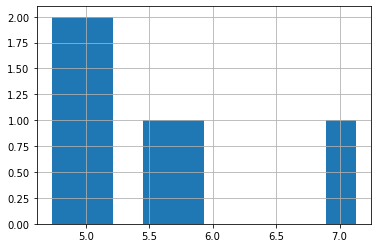

In [50]:
report1 = report.query('buy_month_from_zero  >24214.0')
report1 =  report1.query('cohort_lifetime < 6')
report1['sales_per_user'] = report1['sale']/report1['n_buyers']
lifetime_pivot1 = report1.pivot_table(index='buy_month_from_zero',columns='cohort_lifetime',values='sales_per_user',aggfunc='mean')
lifetime_pivot1 = lifetime_pivot1.reset_index()
lifetime_pivot1['ltv'] = lifetime_pivot1[0.0] + lifetime_pivot1[1.0] +  lifetime_pivot1[2.0] +  lifetime_pivot1[3.0]  +  lifetime_pivot1[4.0] +  +  lifetime_pivot1[5.0]
lifetime_pivot1.ltv.hist(bins = 10)
print('Средний LTV за 6 месяцев:', round(lifetime_pivot1.ltv.mean(), 2))

Маркетинг:

In [51]:
print('Потратили всего денег:', costs['costs'].sum())

Потратили всего денег: 329131.62


In [52]:
print('Потратили денег на каждый источник:')
print(costs.groupby('source_id').agg({'costs': 'sum'}))

Потратили денег на каждый источник:
               costs
source_id           
1           20833.27
2           42806.04
3          141321.63
4           61073.60
5           51757.10
9            5517.49
10           5822.49


Создам несколько функций, которые строят графики для удобства

In [53]:
def grafik(data):
    data.plot(x = 'costs_date_month',
           y = 'costs',
           style = 'o-',
           figsize = (15, 7),
           ax = ax,
           grid = True,
           legend = True)

In [54]:
costs_month = costs.groupby(['source_id', 'costs_date_month']).agg({'costs': 'sum'}).reset_index()

Денег потратили на каждый источник по времени:

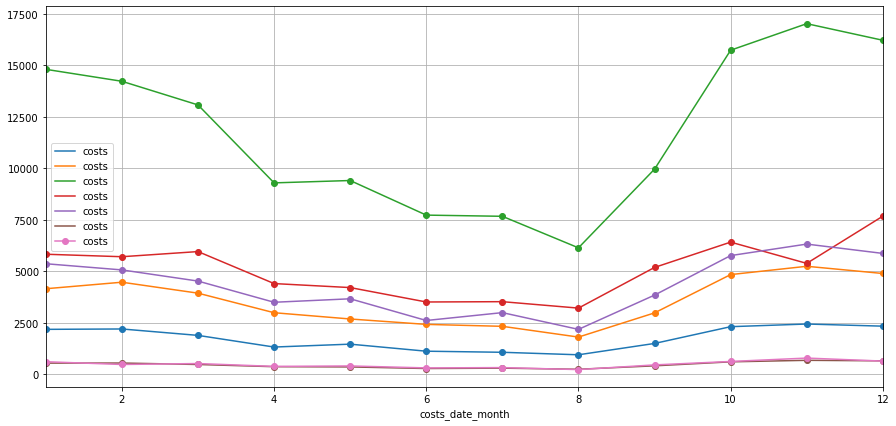

In [55]:
fig, ax = plt.subplots()    
for i in costs_month['source_id'].unique():
    grafik(costs_month.query('source_id == @i'))

In [56]:
def source_on_device(data, column):
    data.plot(x = 'source_id',
           y = column,
           style = 'o-',
           figsize = (15, 7),
           ax = ax,
           grid = True,
           legend = True)

Стоимость привлечения одного покупателя из каждого источника:


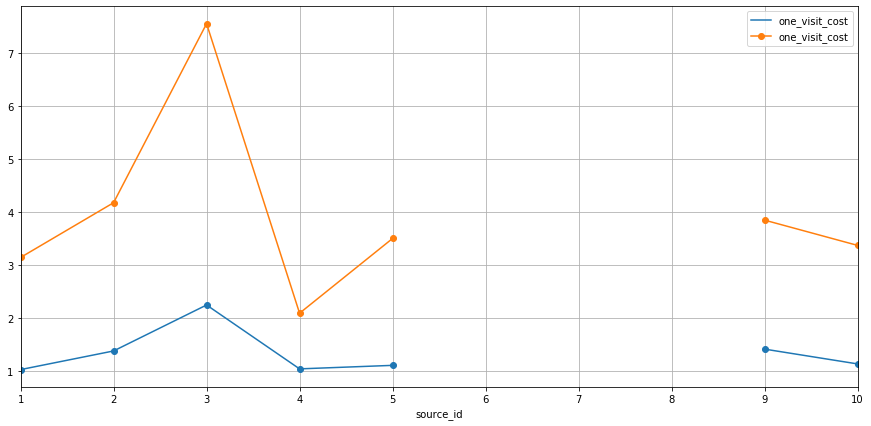

In [57]:
print('Стоимость привлечения одного покупателя из каждого источника:')
#Сгруппируем данные по девайсам, источникам, пользователям и днем первого посещения сайта с суммой продаж
sourse_user = visits.groupby(['device', 'source_id', 'user_id', 'start_time_day']).agg({'sale': 'sum'}).reset_index()
#Сгруппируем данные по девайсам, источникам и днем первого посещения сайта с суммой продаж и количиством уникальных пользователей
count_visitors_in_sourse = sourse_user.groupby(['device', 'source_id', 'start_time_day']).agg({'user_id': 'nunique', 'sale': 'sum'}).reset_index()
#Сгруппируем данные по девайсам и дням первого использования с суммой затрат
count_coasts_in_sourse = costs.groupby(['source_id', 'costs_date_day']).agg({'costs': 'sum'}).reset_index()
#Для удобства слияния переименуем столбцы
count_coasts_in_sourse.set_axis(['source_id', 'start_time_day', 'costs'], axis = 'columns', inplace = True)
#Соединим таблицы по источникам и датам
count_visitors_in_sourse_and_coast = count_visitors_in_sourse.merge(count_coasts_in_sourse, on = ['source_id', 'start_time_day'], how = 'left')
#Посчитаем стоимость привлечения одного посетителя
count_visitors_in_sourse_and_coast['one_visit_cost'] = count_visitors_in_sourse_and_coast['costs'] / count_visitors_in_sourse_and_coast['user_id']
#Сгруппируем по ним таблицу по девайсам и стоимости привлечения одного покупателя
count_one_visit_cost = count_visitors_in_sourse_and_coast.groupby(['device', 'source_id']).agg({'one_visit_cost': 'mean'}).reset_index()
#Рисуем график
fig, ax = plt.subplots()
source_on_device(count_one_visit_cost[count_one_visit_cost['device'] == 'desktop'][['source_id', 'one_visit_cost']], 'one_visit_cost')
source_on_device(count_one_visit_cost[count_one_visit_cost['device'] == 'touch'][['source_id', 'one_visit_cost']], 'one_visit_cost')

Посетители из источников 6 и 7 достались нам бесплатно, но и посетителей таких очень мало

На сколько окупились расходы


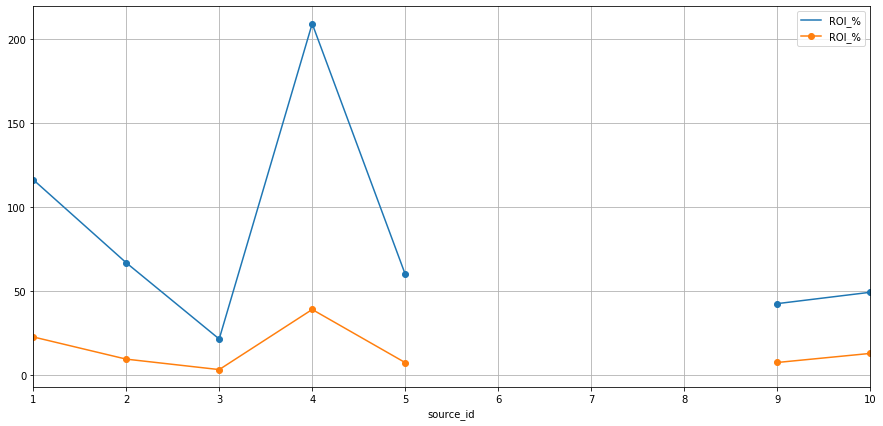

In [58]:
#Считаем количество денег, которые принес один пользоватьель
count_visitors_in_sourse_and_coast['one_visit_sales'] = count_visitors_in_sourse_and_coast['sale'] / count_visitors_in_sourse_and_coast['user_id']
#Считаем ROI
count_visitors_in_sourse_and_coast['ROI_%'] = (count_visitors_in_sourse_and_coast['one_visit_sales'] / count_visitors_in_sourse_and_coast['one_visit_cost'] * 100).round(2)
#Группируем таблицу по девайсами источникам с ROI
count_roi = count_visitors_in_sourse_and_coast.groupby(['device', 'source_id']).agg({'ROI_%': 'mean'}).reset_index()

print('На сколько окупились расходы')
fig, ax = plt.subplots()
source_on_device(count_roi[count_roi['device'] == 'desktop'][['source_id', 'ROI_%']], 'ROI_%')
source_on_device(count_roi[count_roi['device'] == 'touch'][['source_id', 'ROI_%']], 'ROI_%')

In [59]:
roi = count_visitors_in_sourse_and_coast

In [60]:
#Добавлю первый месяц от 00.00.0000 и срок жизни
roi['start_time_day'] = pd.to_datetime(roi['start_time_day'], format='%Y-%m-%d')
roi['start_month_from_zero'] = roi['start_time_day'].dt.year * 12 + roi['start_time_day'].dt.month

first_roi = roi.groupby('source_id').agg({'start_month_from_zero': 'min'}).reset_index()
first_roi.columns = ['source_id', 'first_start_month_from_zero']
roi = roi.merge(first_roi, on='source_id')

roi['month_liftime'] = roi['start_month_from_zero'] - roi['first_start_month_from_zero']

#Отсею все что длилось меньше 6 месяцев
roi = roi.query('month_liftime > 5')

На сколько окупились расходы по месячным когортам(срок жизни кагорты больше 6 месяцев)


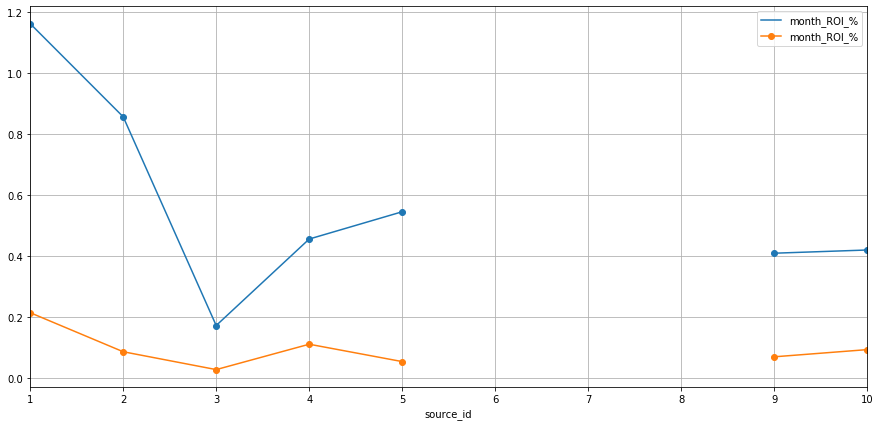

In [61]:
#Посчитаю новый ROI по месяцам
roi_chogort = roi.groupby(['device', 'first_start_month_from_zero', 'source_id']).agg({'costs' : 'sum', 'sale' : 'sum'})
roi_chogort['month_ROI_%'] = roi_chogort['sale'] / roi_chogort['costs']

roi_chogort = roi_chogort.groupby(['device', 'source_id']).agg({'month_ROI_%': 'mean'}).reset_index()

print('На сколько окупились расходы по месячным когортам(срок жизни кагорты больше 6 месяцев)')
fig, ax = plt.subplots()
source_on_device(roi_chogort[roi_chogort['device'] == 'desktop'][['source_id', 'month_ROI_%']], 'month_ROI_%')
source_on_device(roi_chogort[roi_chogort['device'] == 'touch'][['source_id', 'month_ROI_%']], 'month_ROI_%')

ОБЩИЙ ВЫВОД!!!

Среднее колличество людей, которые используют продукт, в день: 908
Среднее колличество людей, которые используют продукт, в неделю: 5825
Среднее колличество людей, которые используют продукт, в месяц: 23228

Медианное число сессий в день: 999

Медианное время сессии(в секундах): 300

Процент вернувшихся пользователей: 90.85

Мода времени между первым заходом на сайт и первой покупкой(в секундах): 0    60.0

Среднее колличество людей, которые покупают продукт, в день: user_id    128
Среднее колличество людей, которые покупают продукт, в неделю: user_id    817
Среднее колличество людей, которые покупают продукт, в месяц: user_id    3155

Показатели среднего чека и LTV схожи по динамике:
-Июньская когорта в сентябре и декабре принесла много денег
Из показателя LTV видно что больше всего денег пользователи приносят в первый месяц использования сайта

Средний LTV за 6 месяцев: 5.44

Потратили всего денег на привлечение: 329131.62

Потратили денег на каждый источник:
Источник       Сумма
1           20833.27
2           42806.04
3          141321.63
4           61073.60
5           51757.10
9            5517.49
10           5822.49

Больше всего денег потратили на 3 источник.
Пользователи смартфонов оказались дороже для привлечения, чем пользователи ПК.
Пользователей ПК больше, чем пользователей смартфонов.
Расходы на пользователей ПК окупаются намного лучше, чем смартфонов.
Показатели ROI по месяцам(с жизнью от 6 месяцев) показали что пользователи ПК окупаются намного лучше, чем смартфонов

Я рекомендую маркетологам большую часть средств сосредоточить на привлечение пользователей ПК.
Рекомендую рассмотреть рекламные источники 6 и 7, тк они бесплатно дают нам пользователей, возможно стоит немного в них инвестировать и будет большой прирост посетителей сайта.
И рекомендую увеличить бюджет на источники 1, 2, 4, 5 так как у них самый большой ROI
Сократить бюджет на источники 3, 9, 10, так как у них не такой большой показатель ROI